<a href="https://colab.research.google.com/github/rabialtafkhan/SfM-Interactive-Virtual-Tour/blob/main/Group7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3D Scene Reconstruction and Virtual Tour**
## Group 7:
### Member 1 (self-appointed leader): **27100418**
### Member 2: **27100376**  

## **Phase 0: Data Collection + Preprocessing**

In [ ]:
import os
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/cv_dataset'
images = []
image_paths = []
count = 0
for filename in sorted(os.listdir(path)):
    if filename.endswith('.jpg'):
        count = count + 1
        img_path = os.path.join(path, filename)
        img = Image.open(img_path)
        images.append(img)
        image_paths.append(img_path)
print("number of images loaded: ", count)
print("size of single image:", images[0].size)

Mounted at /content/drive
number of images loaded:  48
size of single image: (3024, 4032)


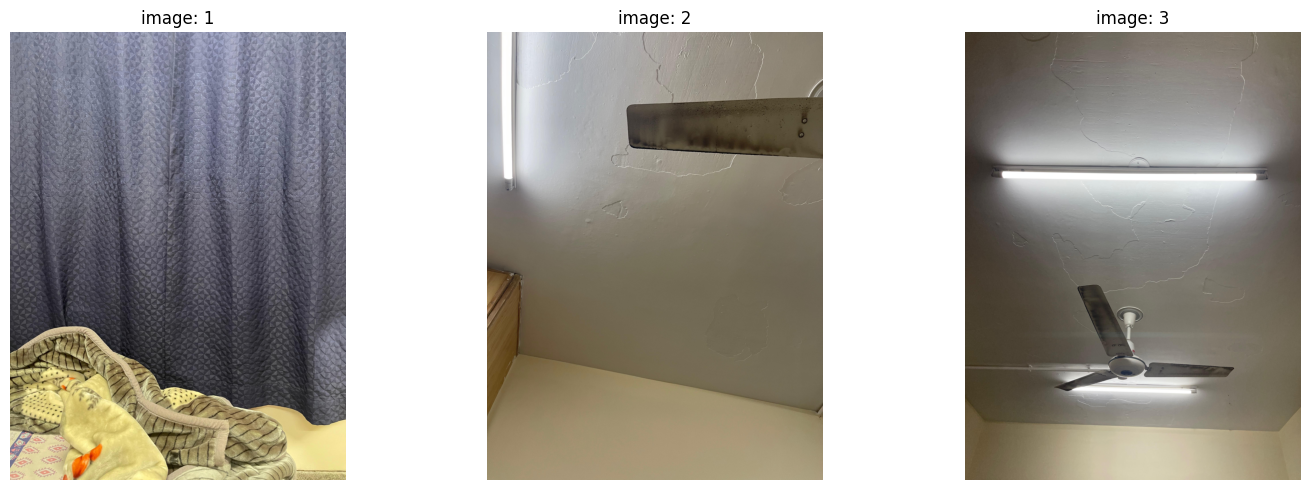

In [ ]:
# display imgs:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, min(3, len(images)), figsize=(15, 5))
for i, img in enumerate(images[:3]):
    axes[i].imshow(img)
    axes[i].set_title(f"image: {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## **Phase 1: The Two-View Foundation**



In [ ]:
import numpy as np
import cv2

In [ ]:
# function that takes in two images -> valid sparse 3D point cloud + saves it as .ply file
def two_view_foundation(path_1, path_2, output_filename='point_cloud.ply'):
  img1 = Image.open(path_1)
  img2 = Image.open(path_2)
  w_1, h_1 = img1.size
  K_1 = np.array([
      [w_1,   0, w_1/2],
      [  0, w_1, h_1/2],
      [  0,   0,     1]
    ])
  img1_cv = cv2.cvtColor(np.array(img1), cv2.COLOR_RGB2BGR)
  img2_cv = cv2.cvtColor(np.array(img2), cv2.COLOR_RGB2BGR)
  sift = cv2.SIFT_create()
  kp_1, des_1 = sift.detectAndCompute(img1_cv, None)
  kp_2, des_2 = sift.detectAndCompute(img2_cv, None)
  # FLANN
  index_params = dict(algorithm=1, trees=5)
  search_params = dict(checks=50) # how many times tree is traversed
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  matches = flann.knnMatch(des_1, des_2, k=2) # k=2 for lowe's ratio test
  good_matches = []
  for m, n in matches:
      if m.distance < 0.7 * n.distance:  # 0.7 is the ratio threshold
          good_matches.append(m)
  if len(good_matches) < 8:
        print(f"⚠️ not enough matches: {len(good_matches)}")
        return None
  points_img1 = np.float32([kp_1[m.queryIdx].pt for m in good_matches])
  points_img2 = np.float32([kp_2[m.trainIdx].pt for m in good_matches])
  # apparently the intrinsic matrices are the same for both imgs bc same camera
  E, inlier_mask = cv2.findEssentialMat(
      points_img1,
      points_img2,
      K_1, # just using 1 for no reason could also be second img's
      method=cv2.RANSAC, # following instructions
      prob=0.999, # v. confidence level
      threshold=1.0  # max reprojection error (in pixels)
  )
  if E is None or E.shape != (3, 3):
        print("⚠️ Failed to compute Essential matrix")
        return None
  num_inliers = np.sum(inlier_mask)
  # decompose E to find 4 relevant camera poses => cv2.recoverPose
  num_inliers, R, t, pose_mask = cv2.recoverPose(
      E,
      points_img1,
      points_img2,
      K_1,
      mask=inlier_mask
  )
  points_img1 = points_img1.reshape(-1, 2)
  points_img2 = points_img2.reshape(-1, 2)
  # triangulate matched 2D points into 3D space for 4 possible poses
  P1 = K_1 @ np.hstack([np.eye(3), np.zeros((3, 1))]) # [I|0]
  P2 = K_1 @ np.hstack([R, t]) # [R|t]
  points_4d = cv2.triangulatePoints(P1, P2, points_img1.T, points_img2.T)
  points_3d = (points_4d[:3] / points_4d[3]).T # homogenous -> 3D
  # perform cheirality test to disambiguiate pose -> find single [R|T] matrix with majority 3D points in front of both cameras
  # done by cv2.recoverPose() alr
  valid = pose_mask.ravel() == 1
  points_3d = points_3d[valid]
  match_img = cv2.drawMatches(img1_cv, kp_1, img2_cv, kp_2, good_matches[:100], None,
                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

  plt.figure(figsize=(20, 10))
  plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
  plt.title(f'Feature Matches: {len(good_matches)} good matches')
  plt.axis('off')
  plt.show()
  with open(output_filename, 'w') as f:
        f.write("ply\nformat ascii 1.0\n")
        f.write(f"element vertex {len(points_3d)}\n")
        f.write("property float x\nproperty float y\nproperty float z\n")
        f.write("end_header\n")
        for p in points_3d:
            f.write(f"{p[0]} {p[1]} {p[2]}\n")
  return points_3d

pair:  1 out of  47


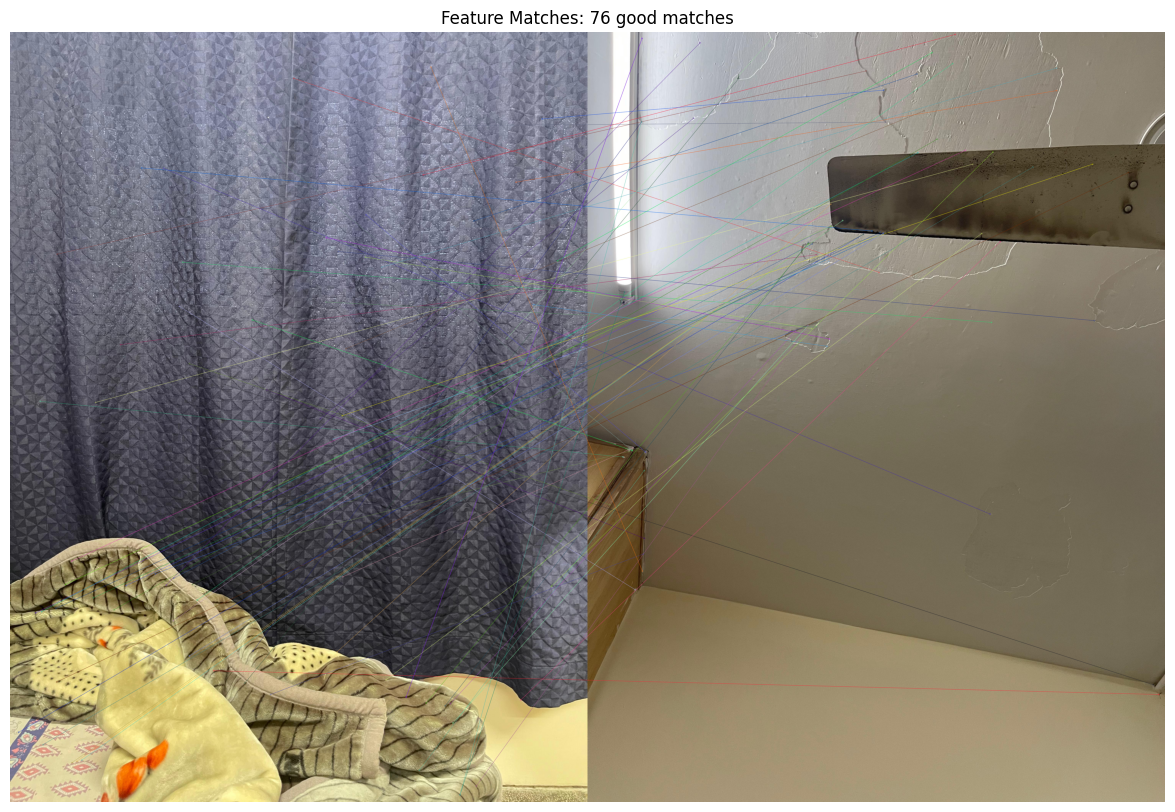

pair:  2 out of  47


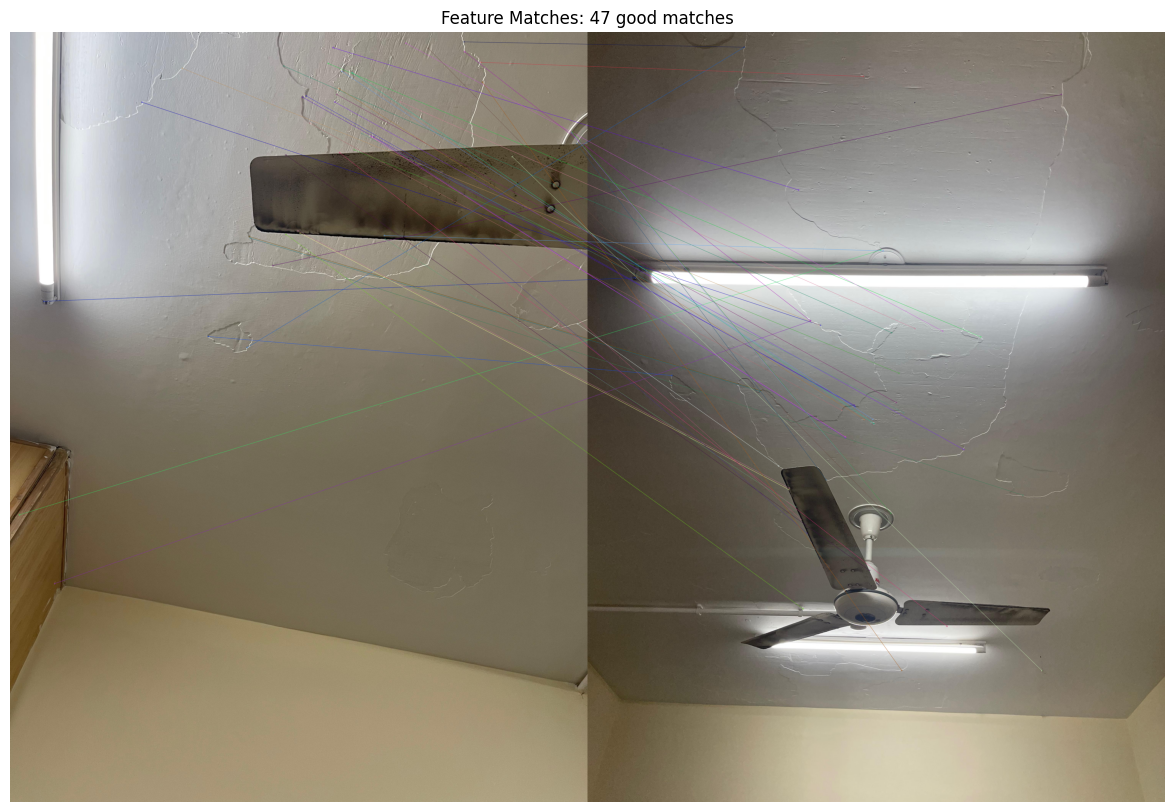

pair:  3 out of  47


KeyboardInterrupt: 

In [ ]:
os.makedirs('/content/drive/MyDrive/cv_dataset/point_clouds', exist_ok=True)
image_paths = sorted(image_paths)
point_clouds = []
for i in range(len(image_paths) - 1):
    print("pair: ", i+1, "out of ", len(image_paths)-1)
    output_file = f'/content/drive/MyDrive/cv_dataset/point_clouds/reconstruction_{i}_{i+1}.ply'
    points = two_view_foundation(image_paths[i], image_paths[i+1], output_file)
    point_clouds.append(points)

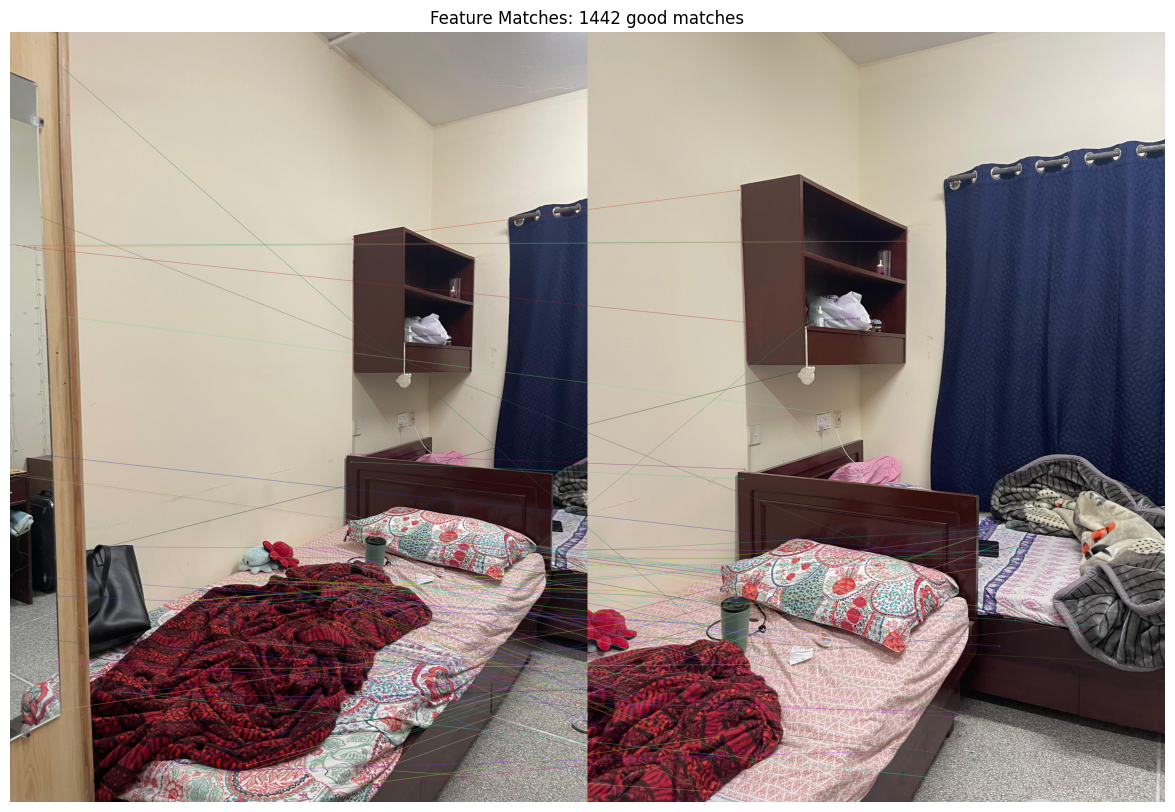

In [ ]:
output_file = '/content/drive/MyDrive/cv_dataset/point_clouds/reconstruction_44_45.ply'
points = two_view_foundation(image_paths[44], image_paths[45], output_file)

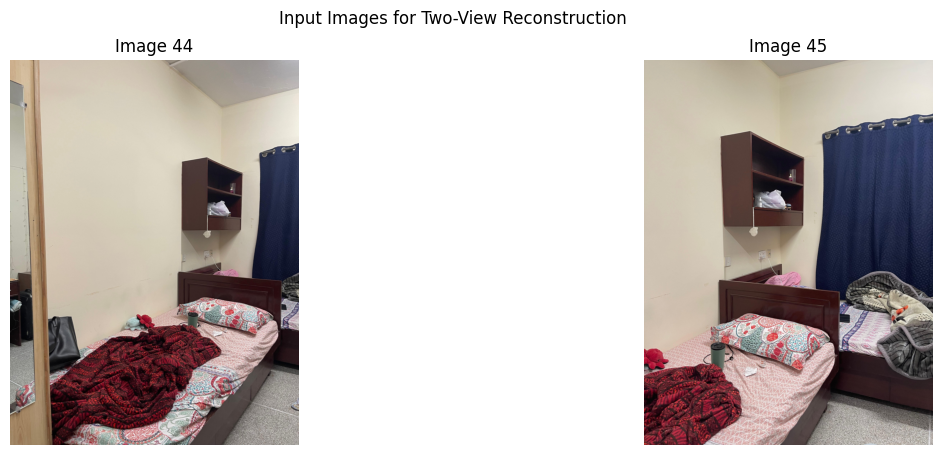

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(images[44])
axes[0].set_title('Image 44')
axes[0].axis('off')
axes[1].imshow(images[45])
axes[1].set_title('Image 45')
axes[1].axis('off')
plt.suptitle('Input Images for Two-View Reconstruction')
plt.show()

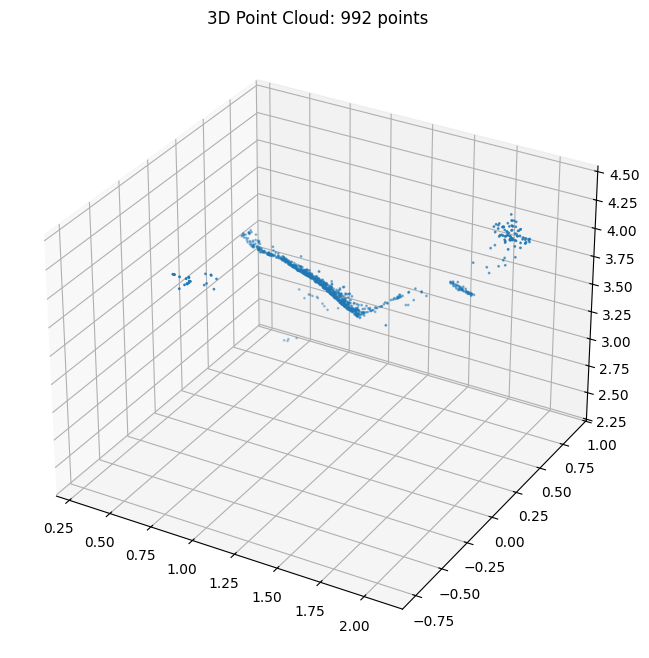

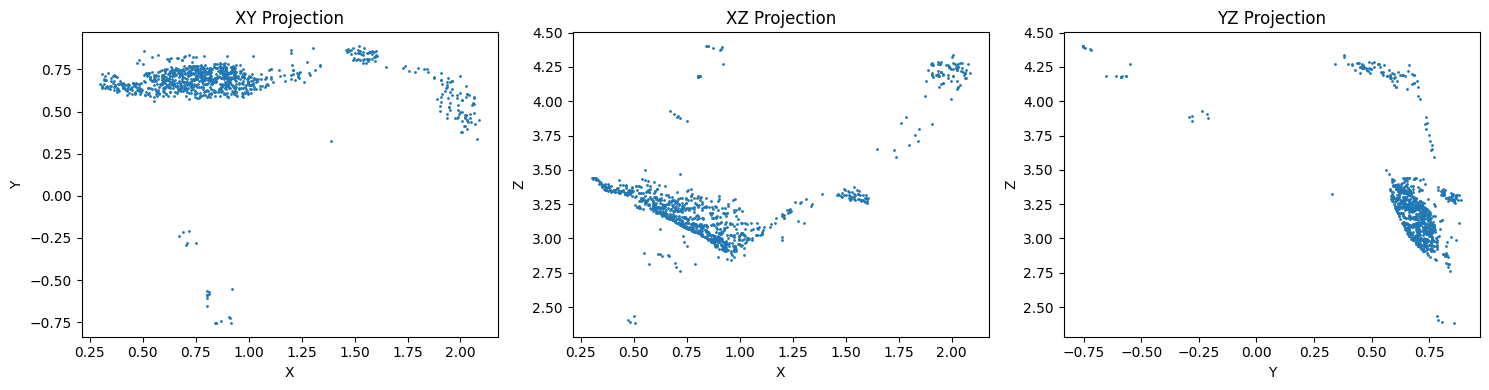

In [ ]:
import glob
ply_files = sorted(glob.glob('/content/drive/MyDrive/cv_dataset/point_clouds/*.ply'))
for ply_file in ply_files:
    if 'reconstruction_44_45' in ply_file:
        points = []
        with open(ply_file, 'r') as f:
            in_data = False
            for line in f:
                if line.startswith('end_header'):
                    in_data = True
                    continue
                if in_data:
                    x, y, z = map(float, line.strip().split())
                    points.append([x, y, z])

        points = np.array(points)

        # 3D visualization
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)
        ax.set_title(f'3D Point Cloud: {len(points)} points')
        plt.show()

        # 2D scatter plots
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        axes[0].scatter(points[:, 0], points[:, 1], s=1)
        axes[0].set_xlabel('X')
        axes[0].set_ylabel('Y')
        axes[0].set_title('XY Projection')

        axes[1].scatter(points[:, 0], points[:, 2], s=1)
        axes[1].set_xlabel('X')
        axes[1].set_ylabel('Z')
        axes[1].set_title('XZ Projection')

        axes[2].scatter(points[:, 1], points[:, 2], s=1)
        axes[2].set_xlabel('Y')
        axes[2].set_ylabel('Z')
        axes[2].set_title('YZ Projection')

        plt.tight_layout()
        plt.show()
        break